<a href="https://colab.research.google.com/github/kabirwalia8300/COVID19_Timeseries/blob/master/COVID19_Japan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREDICTING WHEN NO NEW CASES OF COVID-19 WILL APPEAR IN JAPAN

# STAGE 1: Time Series forecasting using SARIMAX

**Import packages**

In [0]:

import warnings
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import itertools
warnings.filterwarnings("ignore")
import statsmodels.api as sm

from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import statsmodels.tsa.api as smt
import scipy

**Cleaning data and building dataframe**

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url, error_bad_lines=False)

jp = df.loc[df['Country/Region'] == 'Japan']
cols = ['Province/State', 'Lat', 'Long']
jp.drop(cols, axis=1, inplace=True)

Date = list(jp.columns)
Date.remove('Country/Region')

Count = list(jp.iloc[0, :].values)
Count.remove('Japan')

japan = pd.DataFrame(list(zip(Date, Count)), 
               columns =['Date', 'Cases']) 

#setting index
japan['Date'] = pd.to_datetime(japan['Date'])
japan = japan.set_index('Date')
japan

,Cases
Date,
2020-01-22,2
2020-01-23,2
2020-01-24,2
2020-01-25,2
2020-01-26,4
...,...
2020-03-24,1193
2020-03-25,1307
2020-03-26,1387


**Exploratory Data Analysis (EDA)**

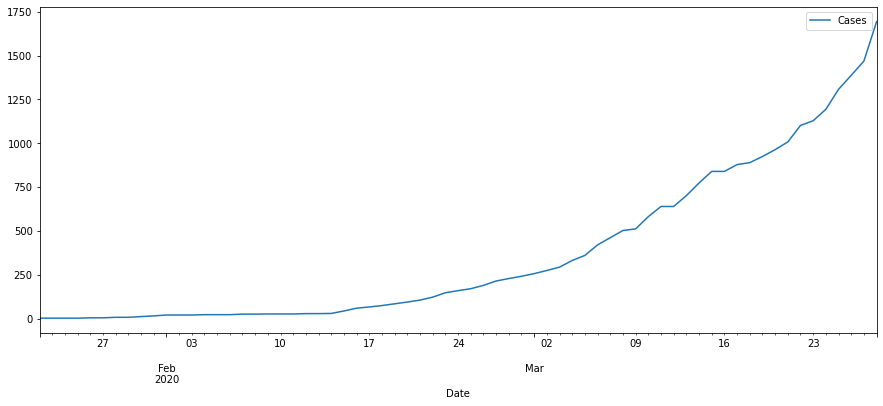

In [3]:
japan.plot(figsize=(15, 6))

Highlights:

- Increasing trend with non-seasonal data (Makes sense as we looking at cumulative confirmed cases)

- Flat lines indicate no new cases on given days

We now decompose the time series curve into its different components

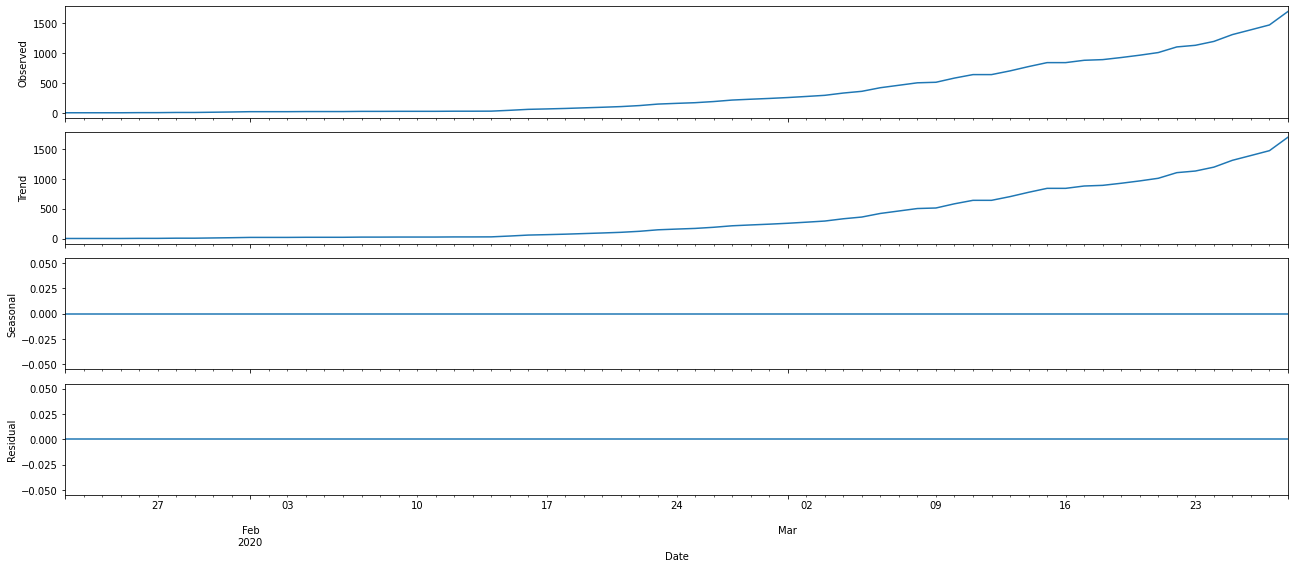

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(japan, model='additive', freq=1) #amplitude of seasonality and irregularity not changing much
fig = decomposition.plot()
plt.show()

Original series captured in trend mainly as expected. Ofcourse this decomposition isn't the most robust.

In [0]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [0]:
original = japan.copy()

In [0]:
japan.Cases = original.Cases

Here I make the data stationary. To do so, the p-value must equal 0.


I have applied a log transformation followed by differencing to the 4th degree. 

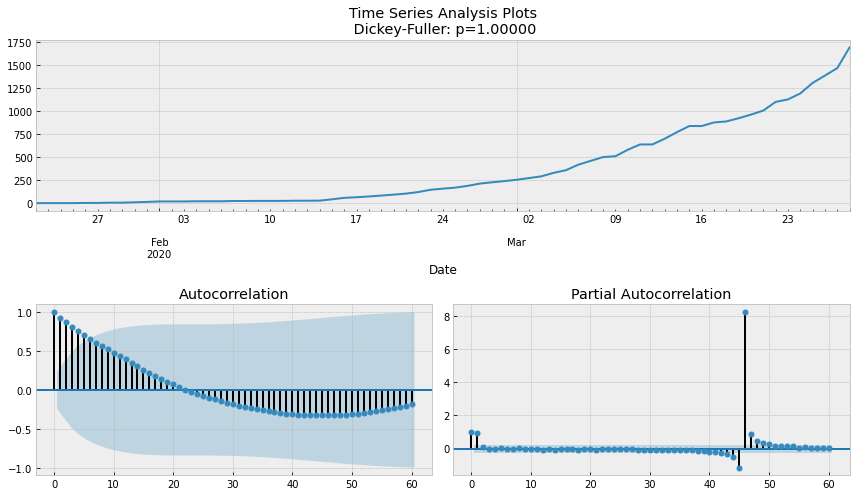

In [9]:
tsplot(original.Cases, lags=60)

The earlier prediciton that the data is non-stationary due to its large trend component was true. We have a large p-value of 1.0000. 

In [0]:
#Log transformation
japan.Cases = np.log(original.Cases)

# japan_diff = japan.Cases

#Differencing to order of 4
japan_diff = japan.Cases - japan.Cases.shift(4)
japan_diff = japan_diff.dropna()

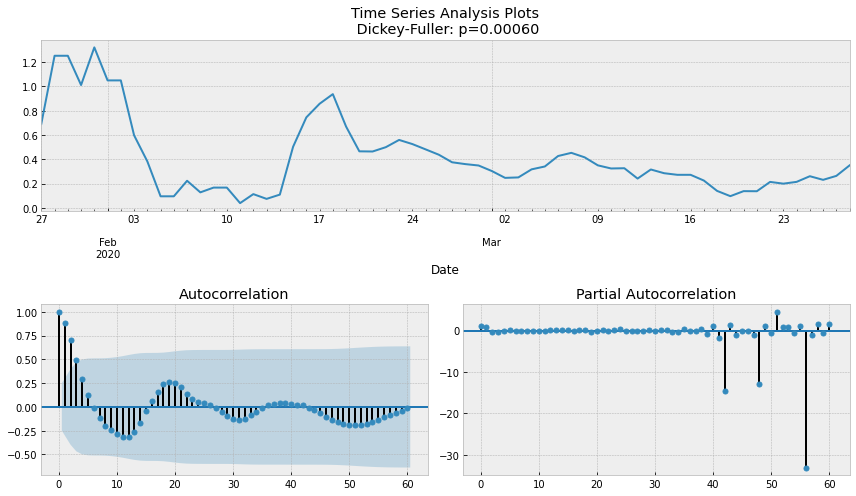

In [13]:
tsplot(japan_diff[1:], lags=60)

After employing techniques to enforce stationarity into the data, we get significantly lower autocorrelations in the data. Although the p-value is exactly zero, I don't do any more differencing (Assumption: that close enough to zero and minimal non-stationarity may not significantly effect the model)

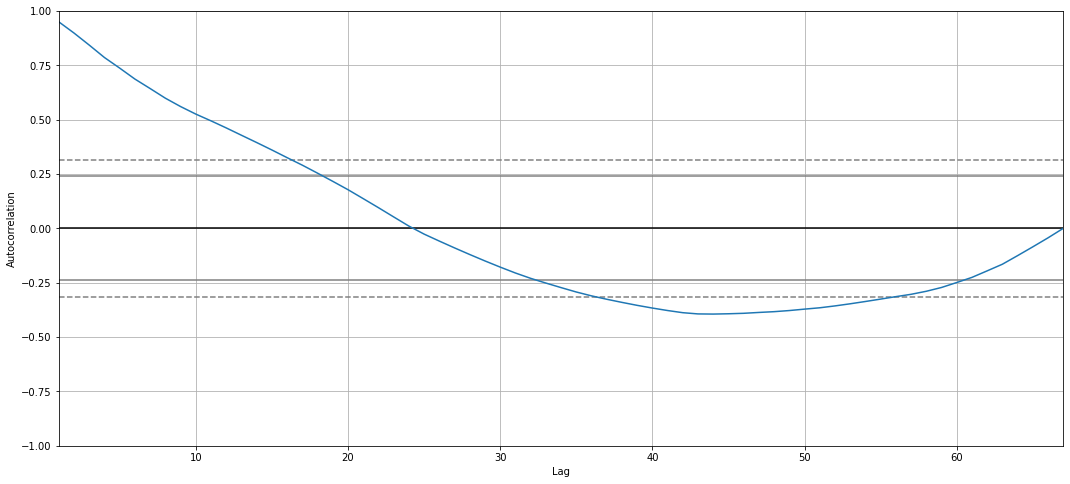

In [10]:
pd.plotting.autocorrelation_plot(japan.iloc[:, 0])

The commented code below is a somewhat grid search algorithm to identify the best parameters to the sarimax model. Based on the method shown here: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3.

(Don't run. Takes a very long time. Used this method on individual values heuristically figured out using the autocorrelation plot above.)

In [0]:
# # evaluate an ARIMA model for a given order (p,d,q)
# def evaluate_arima_model(X, arima_order):
# 	# prepare training dataset
# 	train_size = int(len(X) * 0.66)
# 	train, test = X[0:train_size], X[train_size:]
# 	history = [x for x in train]
# 	# test.reset_index(drop=True, inplace=True)
#   # make predictions
# 	predictions = list()
# 	for t in range(len(test)):
# 		model = sm.tsa.SARIMAX(history, trend='c', order=arima_order, enforce_stationarity=False, enforce_invertibility=False)
# 		model_fit = model.fit(disp=0)
# 		yhat = model_fit.forecast()[0]
# 		predictions.append(yhat)
# 		history.append(test[t])
# 	# calculate out of sample error
# 	error = mean_squared_error(test, predictions)
# 	return error

In [0]:
# # evaluate combinations of p, d and q values for an ARIMA model
# def evaluate_models(dataset, p_values, d_values, q_values):
# 	dataset = dataset.astype('float32')
# 	best_score, best_cfg = float("inf"), None
# 	for p in p_values:
# 		for d in d_values:
# 			for q in q_values:
# 				order = (p,d,q)
# 				try:
# 					mse = evaluate_arima_model(dataset, order)
# 					if mse < best_score:
# 						best_score, best_cfg = mse, order
# 					print('ARIMA%s MSE=%.3f' % (order,mse))
# 				except Exception as ex:
# 					print(ex)
# 					continue
# 	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [0]:
# series = japan.iloc[:, 0]

# # p_values = range(0,10)
# # d_values = range(0, 3)
# # q_values = range(0, 3)
# warnings.filterwarnings("ignore")
# # evaluate_models(series.values, p_values, d_values, q_values)
# # warnings.filterwarnings("ignore")

In [0]:
# p = [20, 21, 22]
# d = q = range(0, 2)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [0]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(japan,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

In [0]:
# Best ARIMA(0, 2, 1) MSE=901.383 --> original method
# Using SARIMAX in original method, got these two: Best ARIMA(1, 0, 0) MSE=897.336 / ARIMA(0, 2, 1) MSE=899.549

# Now trying method two
# ARIMA(0, 1, 0)x(5, 0, 0, 12)12 - AIC:-93.93972616419325
# ARIMA(20, 1, 0)x(0, 1, 1, 12)12 - AIC:310.7267718744117

# ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:361.9116696544985

**Fitting the model**

We now fit the SARIMAX model to the data. (The optimum values of the order parameter and seasonal_order are calculated using the method above.) Roughly one-sixth of the data has been allocated for testing. More the training data the better. 

In [28]:
tr_start,tr_end = '2020-01-22','2020-03-16'
te_start,te_end = '2020-03-17','2020-03-28'
train = japan['Cases'][tr_start:tr_end].dropna()
test = japan['Cases'][te_start:te_end].dropna()


mod = sm.tsa.statespace.SARIMAX(japan,
                                order=(21, 1, 0),
                                seasonal_order=(0, 1, 1, 12)
                                )

results = mod.fit()

print(results.summary().tables[1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1397      0.262      0.533      0.594      -0.374       0.654
ar.L2          0.5650      0.354      1.595      0.111      -0.129       1.259
ar.L3         -0.3713      0.487     -0.763      0.445      -1.325       0.582
ar.L4         -0.1495      0.404     -0.370      0.711      -0.941       0.642
ar.L5          0.2303      0.540      0.426      0.670      -0.829       1.289
ar.L6         -0.0473      0.548     -0.086      0.931      -1.122       1.028
ar.L7          0.0346      0.371      0.093      0.926      -0.692       0.761
ar.L8         -0.2113      0.585     -0.361      0.718      -1.358       0.935
ar.L9         -0.2802      0.595     -0.471      0.638      -1.446       0.886
ar.L10         0.2885      0.339      0.850      0.395      -0.377       0.954
ar.L11         0.0815      0.575      0.142      0.8

The residuals can be seen (top-right) to to distributed normally - closely following the gaussian curve shown. You also see a good fit in the Normal Q-Q plot (bottom-left). Further, the Correlogram indicates low correlations. These indicate that the model is a good fit on the data.


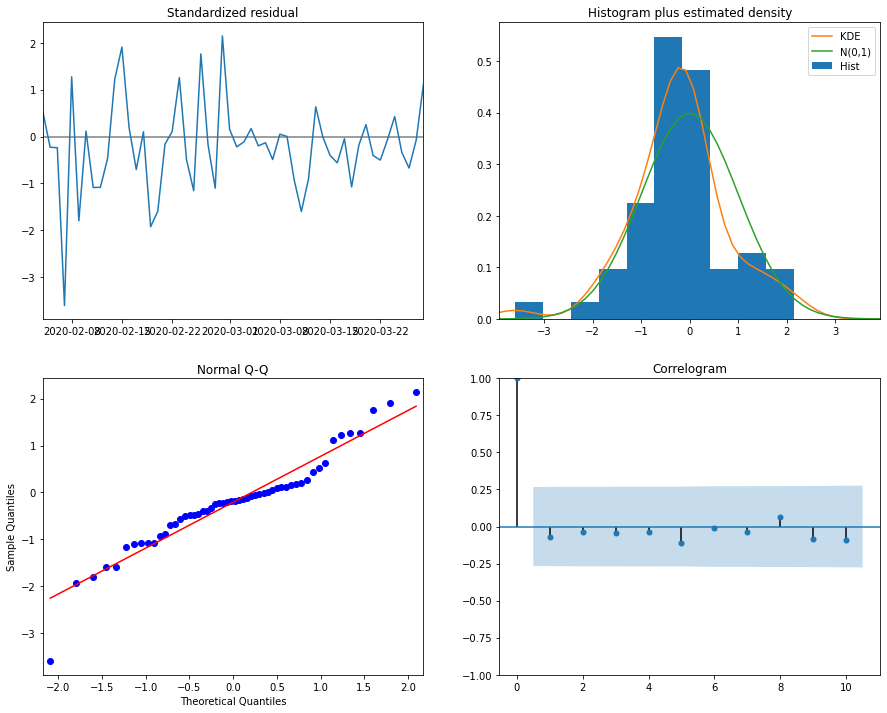

In [29]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**Making the predications on the test data and visualizing it**

In [0]:
pred = results.get_prediction(start=pd.to_datetime(te_start), dynamic=False)
pred_ci = pred.conf_int()

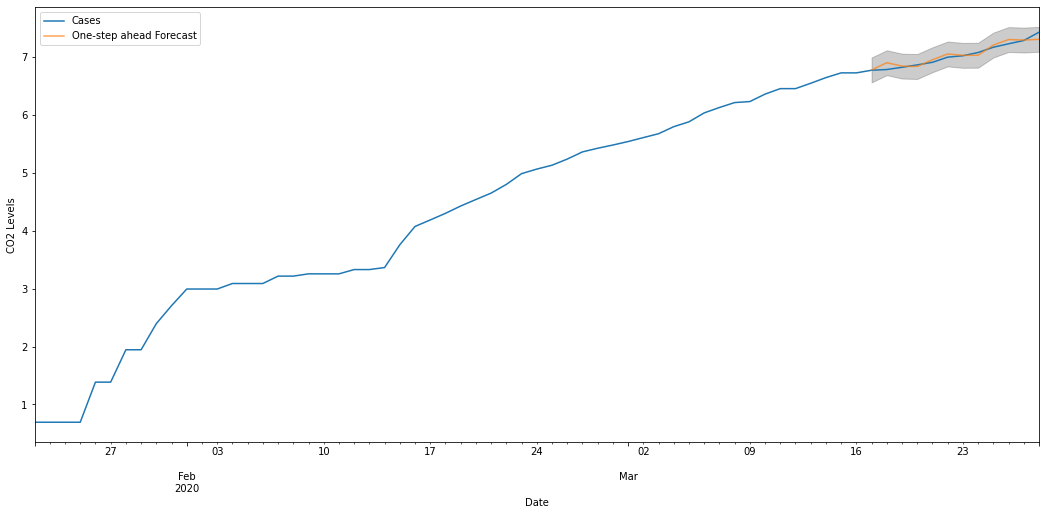

In [31]:
ax = japan['2020-01-22':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

**Model Evaluation**

The SARIMAX model is now evaluated using the MSE metric.

In [32]:
import sklearn
from sklearn.metrics import mean_squared_error

series = japan.iloc[:,0:1]
y_truth = series[te_start:]

print('ARIMA model MSE: {}'.format(mean_squared_error(pred.predicted_mean.astype('int64'),y_truth)))

ARIMA model MSE: 0.3230832533143841


**Forcasting**

The model is now used to forcast the number of COVID-19 cases in the next 100 days.

In [0]:
pred_uc = results.get_forecast(steps=100)

# Confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

Below, the orange line indicates the forecasted values going forward. 

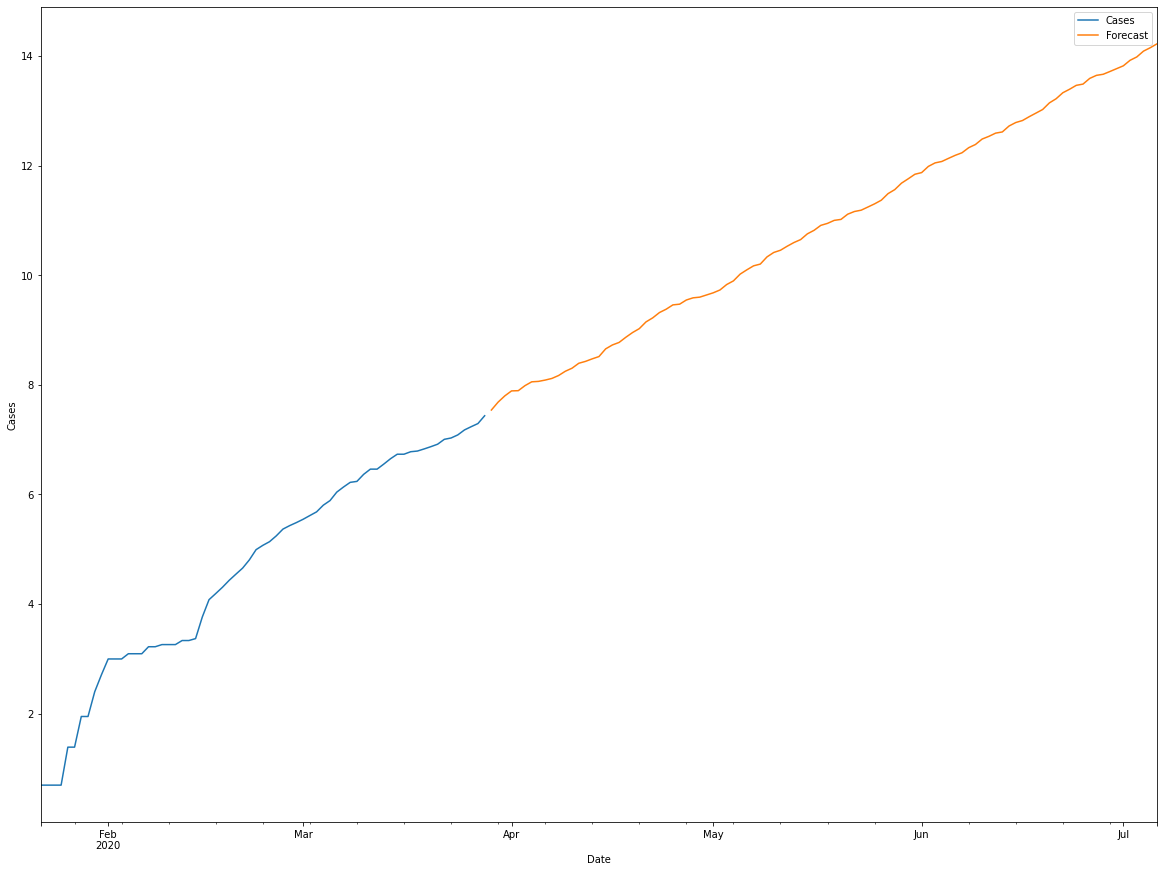

In [37]:
ax = japan.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Cases')

plt.legend()
plt.show()

Here, we are storing the forecasts in a dataframe to be used later.

In [0]:
preds = results.predict(start='2020-03-27', end ='2020-07-27')
forecasts = pd.DataFrame(preds, columns=['Predictions'])

That concludes the time series forecasting.

# STAGE 2: Sigmoid Function Model

We now move on to fit a sigmoid function  - similar to shapes of countries like China where after a slow growth, we see a spike and then eventually the curve flattens out. This will allow us to figure out where the curve will expected to max out, hence giving us a rough estimate of the date.

In [0]:
import scipy
from scipy.optimize import curve_fit

In [0]:
Jap = original
Jap['Days']=range(len(Jap))

x_data = Jap['Days'] 
y_data = Jap['Cases']

**The Sigmoid Function**

In [0]:
def sigmoid(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k*(x-x_0)))

The curve_fit methods returns the optimum parameters to the sigmoid function in optParams. These can then be used to fit the sigmoid function on the data.

In [42]:
optParams, covMatrix = curve_fit(sigmoid, x_data, y_data, bounds=([0,0,0],np.inf), maxfev=5000)
k, x_0, ymax= optParams

print("Best values for k is {}".format(k))
print("Best values for x_0 is {}".format(x_0))
print("Best values for ymax is {}".format(ymax))

Best values for k is 0.0898189196462899
Best values for x_0 is 64.10153740173588
Best values for ymax is 2806.3448901843817


While the above are just parameters to the sigmoid function, the parameter **ymax** is of great interest to us. It represents the value of the 'Cases' at which we expect the curve to flatten; i.e. once the number of COVID-19 cases reaches this number (rounded), there will be no new cases.

**Fitting the model**

In [0]:
y_fitted = sigmoid(x_data, k, x_0, ymax)

**Visualizing the values the model presents for the training data**

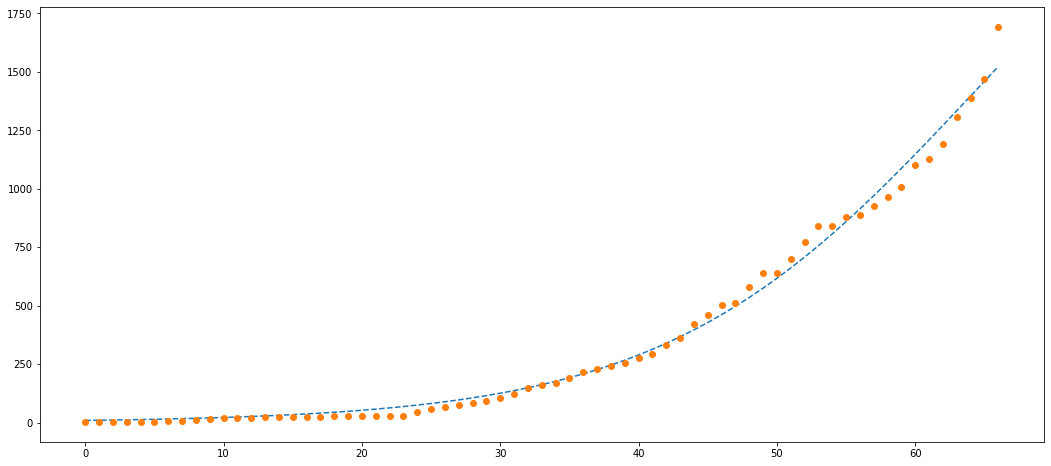

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_data, y_fitted, '--', label='fitted')
ax.plot(x_data, y_data, 'o', label='Confirmed Data')

**Model Evaluation**

In [46]:
lst1 = list(y_fitted)
lst2 = list(y_data)
print("Sigmoid Model MSE is {}".format(mean_squared_error(np.log(lst1), np.log(lst2))))

Sigmoid Model MSE is 0.2944423444303891


The MSE value here is **0.2944** which is extremely close to the MSE value of the SARIMAX model, which was **0.3230**. Thus, both are models are fitting equally well on the data. 

We can also plot the forecasts of both the Sigmoid and SARIMAX models together.

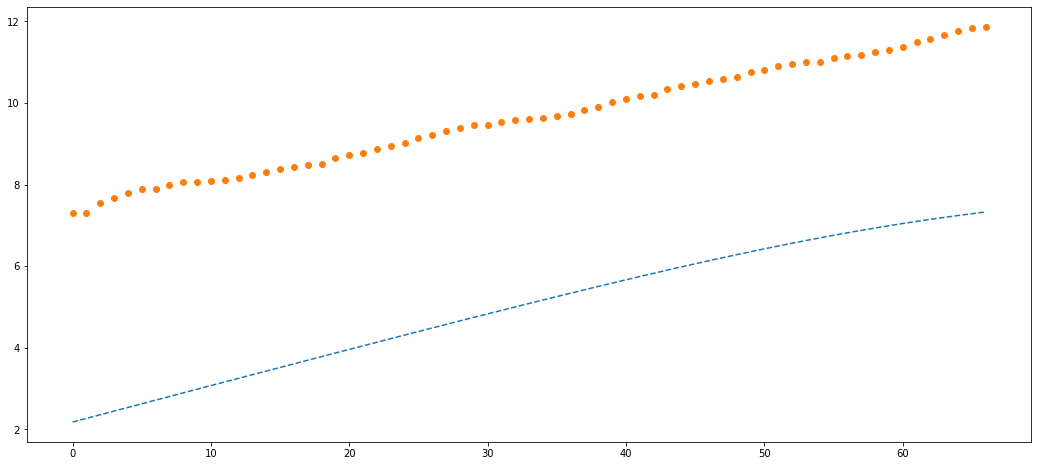

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_data, np.log(y_fitted), '--', label='Sigmoid predictions')
ax.plot(x_data, forecasts['Predictions'][0:67], 'o', label='SARIMAX forecasts')

Slightly shifted but both follow a similar trend.





# Final Prediction Stage
We now leverage the two models above to identify the date at which new cases of COVID-19.




If you recall, the max value of the number of COVID-19 cases (ymax) as predicted by the optimizer for the sigmoid model was **2806.3448901843817**. We can use the log of this value to identify the date at which this log value is attained based on the SARIMAX forecasts.

In [58]:
log_YMAX = np.log(2806.3448901843817)
log_YMAX

7.939638164793055

Below we have all the forecasted values.

In [62]:
forecasts['Predictions']

2020-03-27     7.299531
2020-03-28     7.312005
2020-03-29     7.538467
2020-03-30     7.682809
2020-03-31     7.797028
                ...    
2020-07-23    15.318655
2020-07-24    15.374359
2020-07-25    15.431732
2020-07-26    15.541508
2020-07-27    15.610536
Freq: D, Name: Predictions, Length: 123, dtype: float64

Looks like the first few forecasts have values close to the target.

In [64]:
forecasts['Predictions'].head(15)

2020-03-27    7.299531
2020-03-28    7.312005
2020-03-29    7.538467
2020-03-30    7.682809
2020-03-31    7.797028
2020-04-01    7.887585
2020-04-02    7.891659
2020-04-03    7.983804
2020-04-04    8.053322
2020-04-05    8.061183
2020-04-06    8.085140
2020-04-07    8.115140
2020-04-08    8.168786
2020-04-09    8.246346
2020-04-10    8.302049
Freq: D, Name: Predictions, dtype: float64

Looks like the closest values are **7.891659** and **7.983804** corresponding to dates April 2nd, 2020 and April 3rd, 2020. 
2

# Conclusion

It would be safe to assume that roughly on April 3rd, 2020 no new cases of COVID-19 would be identified in Japan.

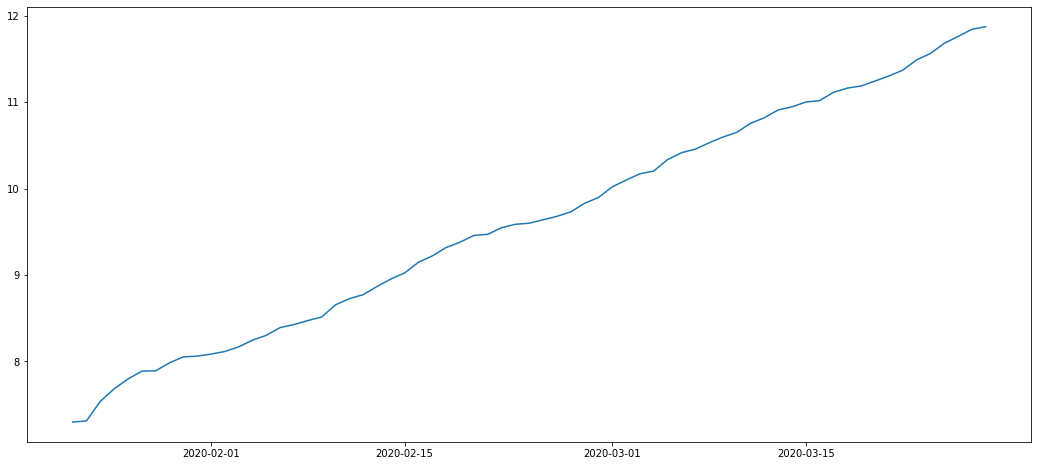

In [107]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(japan.index, forecasts['Predictions'][0:67], '--', label='Forecasts')
# ax.plot(japan.index, [7.983804] , marker='o', label='points')

def AddPoint(plot, x, y, color):
  plt.scatter(x, y, c=color)
  plt.clf()
  

y_ax = forecasts['Predictions'][0:67]
x_ax = japan.index
x = ['2020-04-03']
y = [7.983804]
plt.plot(x_ax, y_ax)
# plt.plot(japan[japan.index=='2020-04-03'].index, forecasts[forecasts.Predictions==7.983804].Predictions, 'ro')
# type(x_ax)

plt.show()


[59, 61, 62]


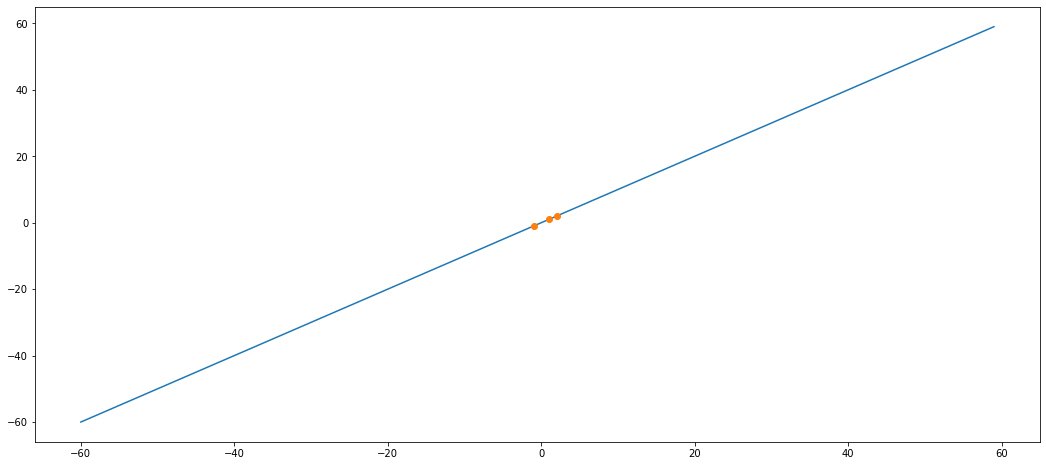

In [69]:
import matplotlib.pyplot as plt

vals,poly = range(-60,60), range(-60,60)

plt.plot(vals, poly, label='some graph')
roots = [-1,1,2]

mark = [vals.index(i) for i in roots]
print(mark)
plt.plot(vals,poly,markevery=mark, ls="", marker="o", label="points")

plt.show()